# Plotting and filtering Lagrangian and Euleian data
## First, I load the Eulerian fields

In [9]:
#I need to load the same time period in the Eulerian and Lagrangian data. The Eulerian data starts earlier. The following calculation find how much earlier
30096/144 #timestep 0 is this step

209.0

In [10]:

337/2 #168 timesteps before timestep 0 

168.5

In [11]:
209-168 # this is the first timestep covered by the Lagrangian run

41

In [13]:
209+168 # this is the last timestep covered by the Lagrangian run

377

In [14]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

In [15]:
uvel_merged = xr.open_dataset('/swot/SUM01/spencer/swot_agulhas_surf/uvel.nc')
vvel_merged = xr.open_dataset('/swot/SUM01/spencer/swot_agulhas_surf/vvel.nc')

uvel_merged = uvel_merged.isel(time=slice(41,378))

vvel_merged = vvel_merged.isel(time=slice(41,378))

uvel_merged['time'] = uvel_merged['time']/ np.timedelta64(1, 's')
vvel_merged['time'] = vvel_merged['time']/ np.timedelta64(1, 's')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [16]:
#calculate power spectrum in Eulerian space
with ProgressBar():
    uhat2 = xrft.power_spectrum(grid.interp(uvel_merged.U,'X'),dim='time', detrend='linear', window=True).compute()
    vhat2 = xrft.power_spectrum(grid.interp(vvel_merged.V,'Y',boundary='fill'),dim='time', detrend='linear', window=True).compute()
ekehat_eul = .5*(uhat2 + vhat2)


## Then, I load the lagrangian fields

In [17]:
ds = xr.open_zarr('/swot/SUM01/spencer/run_1week_rechunked.zarr')

In [18]:
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)
ds = ds.dropna('npart')

In [19]:
mask_roundx = abs(ds.x.diff('time')).max('time')
mask_roundy = abs(ds.y.diff('time')).max('time')
ds = ds.where(mask_roundx<30)
ds = ds.where(mask_roundy<30)
ds = ds.dropna('npart')

In [20]:
#Calculate power spectrum in Lagrangian space
with ProgressBar():
    uhat2 = xrft.power_spectrum(ds.u.drop('niter'),dim='time', detrend='linear', window=True).compute()
    vhat2 = xrft.power_spectrum(ds.v.drop('niter'),dim='time', detrend='linear', window=True).compute()
ekehat = .5*(uhat2 + vhat2)

[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed |  1min  0.1s


In [32]:
spec0 = int((ekehat['freq_time'].size+1)/2)

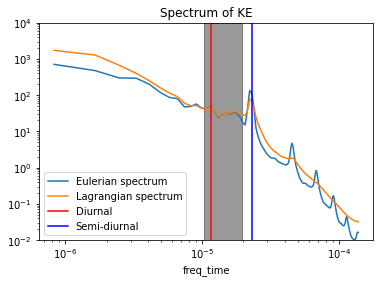

In [33]:
#Plot Lagrangian and Eulerian power spectrum
f1 = 2*2*np.pi/24/3600*np.sin(-57*np.pi/180)
f2 = 2*2*np.pi/24/3600*np.sin(-26.6*np.pi/180)
ekehat_eul.mean(['i','j'])[spec0:].plot(label="Eulerian spectrum")
ekehat.mean(['npart'])[spec0:].plot(label='Lagrangian spectrum')

plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
#plt.axvline([-f1/2/np.pi],label='Inertial 1',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
bottom, height = 0, 10**8
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')
plt.ylim(10**-2,10**4)

fig=plt.gcf()
fig.savefig('agulhas_spectrum_lagrang.pdf')

# Plot rotary spectrum in order to characerize near-inertial motions

In [34]:
z=ds.u.drop('niter')+1j*ds.v.drop('niter')
with ProgressBar():
    z2 = xrft.power_spectrum(z,dim='time', detrend='linear', window=True).compute()

[########################################] | 100% Completed |  1min 59.1s


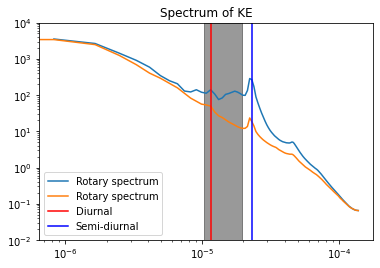

In [35]:
plt.plot(z2.freq_time[spec0:],z2.mean(['npart'])[spec0:],label='Rotary spectrum')
plt.plot(-z2.freq_time[spec0::-1],z2.mean(['npart'])[spec0::-1],label='Rotary spectrum')
plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
#plt.axvline([-f1/2/np.pi],label='Inertial 1',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
bottom, height = 0, 10**8
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')
plt.ylim(10**-2,10**4)

fig=plt.gcf()
fig.savefig('rotary_spectrum.pdf')

# Calculate energy as a function of space

In [36]:
#define frequency spacing and integrate
dfreq = ekehat.freq_time[spec0:].diff('freq_time')[1]
EKE_lag = (ekehat[spec0:,:]*dfreq).sum('freq_time')
EKE_eul = (ekehat_eul[spec0:,:,:]*dfreq).sum('freq_time')

In [22]:
EKE_lag_pd = EKE_lag.rename('EKE_lag').to_dataframe().drop(columns="freq_time_spacing")
x_pd = ds.x.sel(time=0).to_dataframe()
y_pd = ds.y.sel(time=0).to_dataframe()
merged_pd = x_pd.drop(columns=["niter","time"]).join(y_pd).drop(columns=["niter","time"])

In [38]:
import pandas as pd
index = pd.MultiIndex.from_frame(merged_pd)
df = pd.DataFrame(EKE_lag_pd.EKE_lag.values, index=index)

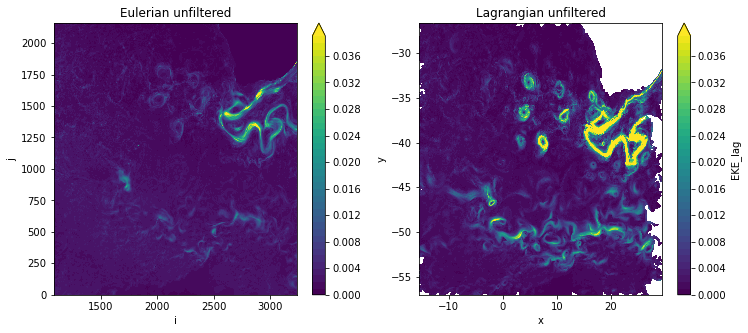

In [39]:
plt.figure(figsize=(12,5))
plt.subplot(121)
EKE_eul.plot.pcolormesh(levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Eulerian unfiltered')
plt.subplot(122)
EKE_lag_reshaped = df.rename(columns={0: "EKE_lag"}).to_xarray()
EKE_lag_reshaped.EKE_lag.plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Lagrangian unfiltered')
fig=plt.gcf()
fig.savefig('KE_unfiltered.pdf')

## Now let's do a filter at a single frequency of 0.9* the minimum f

In [40]:
max_freq = (-f2/2/np.pi)*0.9
max_freq

9.32831432997437e-06

In [133]:
#np.argmax()#[180]#.sel(ekehat.freq_time<max_freq)
spec_cut = (ekehat.freq_time[spec0:]<max_freq).argmin().values+spec0

In [134]:
EKE_eul_filtered = (ekehat_eul[spec0:spec_cut,:,:]*dfreq).sum('freq_time')

In [135]:
EKE_lag_filtered = (ekehat[spec0:spec_cut,:]*dfreq).sum('freq_time')
EKE_lagf_pd = EKE_lag_filtered.rename('EKE_lag').to_dataframe().drop(columns="freq_time_spacing")
df_filtered = pd.DataFrame(EKE_lagf_pd.EKE_lag.values, index=index)

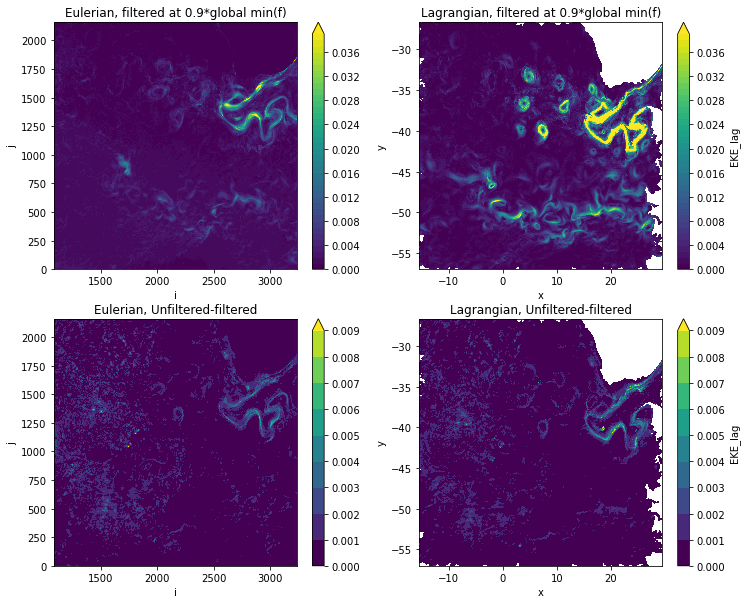

In [136]:
plt.figure(figsize=(12,10))
plt.subplot(221)
EKE_eul_filtered.plot.pcolormesh(levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Eulerian, filtered at 0.9*global min(f)')
plt.subplot(222)
EKE_lag_reshaped_filered = df_filtered.rename(columns={0: "EKE_lag"}).to_xarray()
EKE_lag_reshaped_filered.EKE_lag.plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Lagrangian, filtered at 0.9*global min(f)')
plt.subplot(223)
(EKE_eul-EKE_eul_filtered).plot.pcolormesh(levels=np.arange(0,0.01,0.001),rasterized=True)
plt.title('Eulerian, Unfiltered-filtered')
plt.subplot(224)
(EKE_lag_reshaped.EKE_lag-EKE_lag_reshaped_filered.EKE_lag
).plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.01,0.001),rasterized=True)
plt.title('Lagrangian, Unfiltered-filtered')
fig=plt.gcf()
fig.savefig('KE_filtered.pdf')

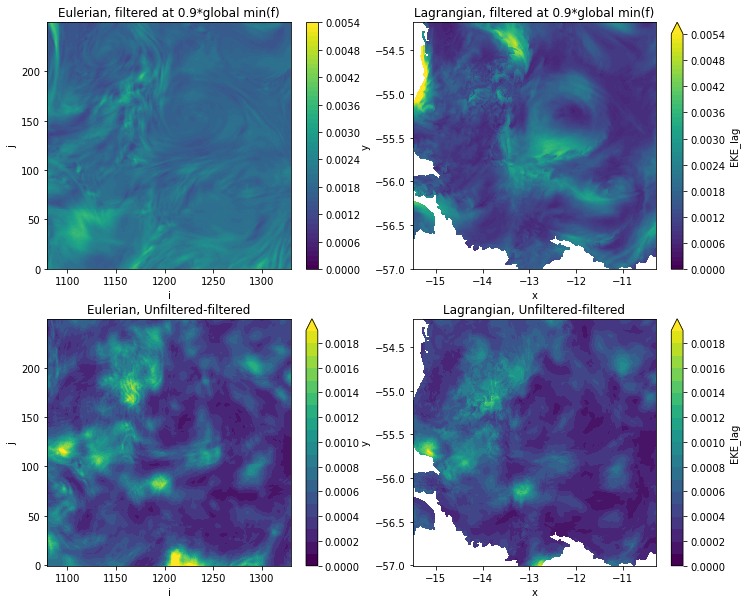

In [68]:
plt.figure(figsize=(12,10))
plt.subplot(221)
EKE_eul_filtered[0:250,0:250].plot.pcolormesh(levels=np.arange(0,0.0055,0.0001),rasterized=True)
plt.title('Eulerian, filtered at 0.9*global min(f)')
plt.subplot(222)
EKE_lag_reshaped_filered.EKE_lag[0:250,0:250].plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.0055,0.0001),rasterized=True)
plt.title('Lagrangian, filtered at 0.9*global min(f)')
plt.subplot(223)
(EKE_eul-EKE_eul_filtered)[0:250,0:250].plot.pcolormesh(levels=np.arange(0,0.002,0.0001),rasterized=True)
plt.title('Eulerian, Unfiltered-filtered')
plt.subplot(224)
(EKE_lag_reshaped.EKE_lag-EKE_lag_reshaped_filered.EKE_lag
)[0:250,0:250].plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.002,0.0001),rasterized=True)
plt.title('Lagrangian, Unfiltered-filtered')
fig=plt.gcf()
fig.savefig('KE_zoom.pdf')

## Now let's do a filter at 0.9* the minimum f each trajectory (lagrangian only)

In [99]:
ekehat_labeled = ekehat.assign_coords({"min_lat":ds.y.min('time')})
f_local = 2*2*np.pi/24/3600*np.sin(ekehat_labeled.min_lat*np.pi/180)
maxfreq_local = (-f_local/2/np.pi)*0.9

In [102]:
spec_cut = (ekehat.freq_time[spec0:]<maxfreq_local).argmin('freq_time').values+spec0

In [113]:
EKE_lag_locfiltered = (ekehat[spec0:,:].where(ekehat.freq_time[spec0:]<maxfreq_local)*dfreq).sum('freq_time')
EKE_lagfloc_pd = EKE_lag_locfiltered.rename('EKE_lag').to_dataframe().drop(columns="freq_time_spacing")
df_locfiltered = pd.DataFrame(EKE_lagfloc_pd.EKE_lag.values, index=index)

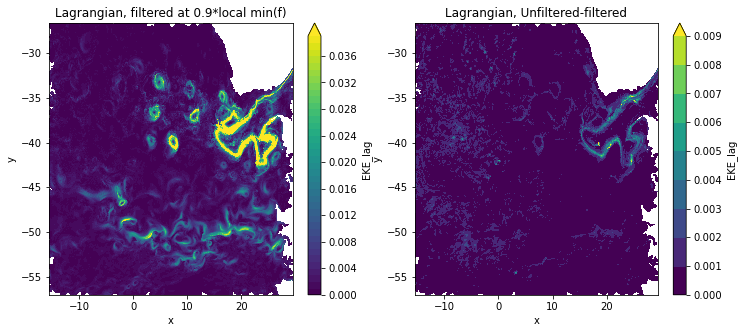

In [138]:
plt.figure(figsize=(12,5))
plt.subplot(121)
EKE_lag_reshaped_locfilered = df_locfiltered.rename(columns={0: "EKE_lag"}).to_xarray()
EKE_lag_reshaped_locfilered.EKE_lag.plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Lagrangian, filtered at 0.9*local min(f)')
plt.subplot(122)
(EKE_lag_reshaped.EKE_lag-EKE_lag_reshaped_filered.EKE_lag
).plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.01,0.001),rasterized=True)
plt.title('Lagrangian, Unfiltered-filtered')
fig=plt.gcf()
fig.savefig('KE_filtered_local.pdf')

In [119]:
EKE_eul.max().values

array(0.0636182)

In [117]:
from xhistogram.xarray import histogram

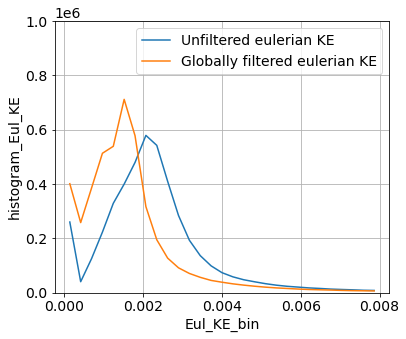

In [147]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(6,5))
bins = np.linspace(0, 0.008, 30)

h = histogram(EKE_eul.rename('Eul_KE'), bins=[bins])
h.plot(label='Unfiltered eulerian KE')
plt.title('Probability density function')
plt.ylim(0,10**6)

h = histogram(EKE_eul_filtered.rename('Eul_KE'), bins=[bins])
h.plot(label='Globally filtered eulerian KE')
plt.ylim(0,10**6)
plt.grid()
plt.legend()
fig=plt.gcf()
fig.savefig('eulerian_KE_pdf.pdf')

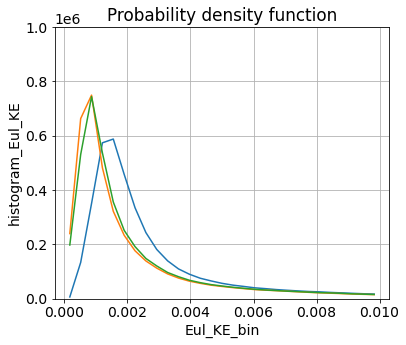

In [148]:
plt.figure(figsize=(6,5))
bins = np.linspace(0, 0.01, 30)

h = histogram(EKE_lag_reshaped.EKE_lag, bins=[bins])
h.plot(label='Unfiltered lagrangian KE')
plt.ylim(0,10**6)
plt.grid()


h = histogram(EKE_lag_reshaped_filered.EKE_lag.rename('Eul_KE'), bins=[bins])
h.plot(label='Globally filtered lagrangian KE')
plt.ylim(0,10**6)
plt.grid()



h = histogram(EKE_lag_reshaped_locfilered.EKE_lag.rename('Eul_KE'), bins=[bins])
h.plot(label='Locally filtered lagrangian KE')
plt.title('Global filter lagrangian KE pdf')
plt.ylim(0,10**6)
plt.grid()
plt.title('Probability density function')
fig=plt.gcf()
fig.savefig('lagrangian_KE_pdf.pdf')